In [4]:
## preparation

# some common imports
import importlib

# import hyptrails
import trails.hyptrails
importlib.reload(trails.hyptrails)
from trails.hyptrails import *

# numpy 
import numpy as np

# prepare plotting
%matplotlib inline

# set figure size; src: http://txt.arboreus.com/2012/12/13/change-figure-size-in-ipython-notebook-sessions.html
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 15, 8

# import matplotlib
import matplotlib.pyplot as plt

# prepare illustration
%load_ext tikzmagic

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


# MixedTrails
Compared to [HypTrails](http://hyptrails.github.io) we aim at
* building more intricate hypotheses allowing to encode different hypotheses for 
    * different user groups or 
    * "topics" of path histories (instead of switching to the next Markov chain order)


## Experiments

In [6]:
# experimental setup

# kappa for all experiments
kappa = np.array([0,1,2,3,4,5,10,20,100,1000,10000,100000,1000000])

# smoothing for all experiments
smoothing = 1

### Experiment 1

First we randomly create a graph and visualize it.

In [8]:
import networkx as nx

# graph constants
n_states = 100
p_edge = 0.5
p_state_classes = [0.5, 0.5]

# derived constants
n_state_classes = len(p_state_classes)

# create graph
graph = nx.fast_gnp_random_graph(n_states, p_edge)

# get adjacency matrix as array
adjacency_matrix = np.asarray(nx.to_numpy_matrix(graph))

# set state classes according to class probabilities
state_class_distribution = np.random.multinomial(n_states, p_state_classes)
state_classes = np.repeat(\
    range(0, n_state_classes), \
    state_class_distribution)

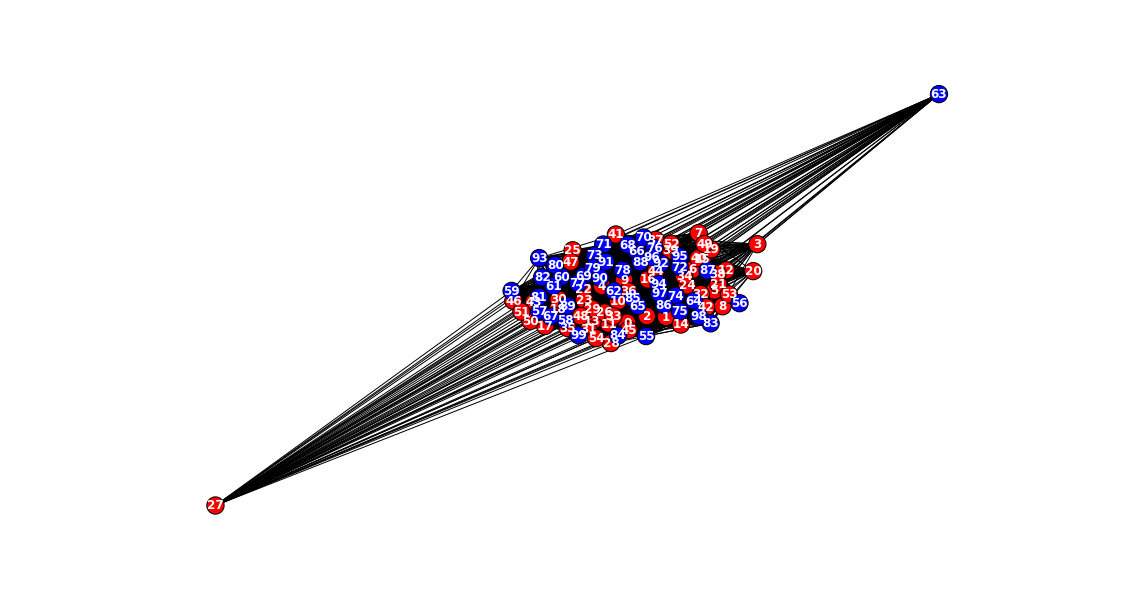

In [9]:
# draw graph
colors=['r', 'b', 'g', 'y', 'm', 'c']
state_colors = np.repeat(colors[0:len(p_state_classes)], state_class_distribution)
nx.draw(graph, node_color=state_colors, font_color='w', with_labels=True, font_weight="bold", arrows=True)
plt.show()

Then we create some transition matrices which we use for random walkers as well as for hypotheses.

In [10]:
import trails.transition_probabilities as tp


# transition matrices

tp_random = tp.random(adjacency_matrix, state_classes)
tp_links = tp.links(adjacency_matrix, state_classes)
tp_group_homo = tp.group_homo(adjacency_matrix, state_classes)
tp_group_homo_weighted = tp.group_homo_weighted(10, adjacency_matrix, state_classes)

# print("Adjacency matrix")
# print(adjacency_matrix)

# print("\nRandom")
# print(tp_random)

# print("\nLinks")
# print(tp_links)

# print("\nHomo")
# print(tp_group_homo)

# print("\nHomo Weighted (weight=2)")
# print(tp_group_homo_weighted)

In [11]:
import trails.randomwalk.randomwalk as rw
import trails.randomwalk.next_state as next_state
import trails.randomwalk.keep_walking as keep_walking
import trails.randomwalk.first_state as first_state
import trails.randomwalk.transition_matrix as tm
importlib.reload(tm)
importlib.reload(first_state)

import trails.group_assignment as group_assignment
importlib.reload(group_assignment)

# random walker constants
n_random_walkers = 10000
p_random_walker_classes = [0.5, 0.5]
n_steps = 10

# derived constants
n_random_walker_classes = len(p_random_walker_classes)

# set random walker classes
random_walker_class_distribution = \
    np.random.multinomial(n_random_walkers, p_random_walker_classes)
random_walker_classes = np.repeat(\
    range(0,n_random_walker_classes), \
    random_walker_class_distribution)

# next step

next_random = next_state.init_matrix(\
        tp_random)

next_links = next_state.init_matrix(\
        tp_links)

next_homo = next_state.init_grouped_matrix(\
        group_assignment.walker, \
        tp_group_homo)

next_memory = next_state.init_grouped_matrix(\
        group_assignment.memory, \
        [tp_links, tp_group_homo[0], tp_group_homo[1]])

next_homo_weighted = next_state.init_grouped_matrix(\
        group_assignment.walker, \
        tp_group_homo_weighted)

next_memory_weighted = next_state.init_grouped_matrix(\
        group_assignment.memory, \
        [tp_links, tp_group_homo_weighted[0], tp_group_homo_weighted[1]])


# walk the random walk
r = rw.RandomWalk(adjacency_matrix, state_classes)
walks = r.walk( \
    random_walker_classes, \
    next_links, \
    keep_walking.init_fixed(n_steps),\
    first_state.random)

#print(walks)

In [12]:
import trails.utils as utils 
import trails.transition_probabilities as tp
importlib.reload(tp)

import trails.group_assignment as group_assignment
importlib.reload(group_assignment)


importlib.reload(tm)

# derive transition matrices

transition_matrix = tm.transition_matrix(walks, len(state_classes))

grouped_transition_matrix_random = tm.grouped_transition_matrix(\
    group_assignment.init_random(2), 2,\
    walks, adjacency_matrix, state_classes)

grouped_transition_matrix_walker = tm.grouped_transition_matrix(\
    group_assignment.walker, n_state_classes,\
    walks, adjacency_matrix, state_classes)

grouped_transition_matrix_memory = tm.grouped_transition_matrix(\
    group_assignment.memory, n_state_classes + 1,\
    walks, adjacency_matrix, state_classes)

groups_assignments = [group_assignment.walker, group_assignment.memory]
number_of_groups = [len(grouped_transition_matrix_walker), len(grouped_transition_matrix_memory)]
grouped_transition_matrix_proxy = tm.grouped_transition_matrix(\
    group_assignment.init_proxy(groups_assignments, number_of_groups), \
    group_assignment.proxy_count(number_of_groups), \
    walks, adjacency_matrix, state_classes)


#print(adjacency_matrix)
#print(transition_matrix)
#print(grouped_transition_matrix_random)
#print(grouped_transition_matrix_walker)
#print(grouped_transition_matrix_memory)
#print(grouped_transition_matrix_proxy)

# hypotheses (single)
hyp_perfect =  utils.norm1_2d(transition_matrix)
hyp_random = utils.norm1_2d(np.ones(transition_matrix.shape))
hyp_links = utils.norm1_2d(adjacency_matrix)
hyp_red = utils.norm1_2d(tp_group_homo[0])
hyp_blue = utils.norm1_2d(tp_group_homo[1])

# hypotheses (groups)
hyp_groups_random_perfect = utils.norm1_3d(grouped_transition_matrix_random)

hyp_groups_homo_perfect = utils.norm1_3d(grouped_transition_matrix_walker)
hyp_groups_homo = tp_group_homo
hyp_groups_homo_weighted = tp_group_homo_weighted

hyp_groups_memory_perfect = utils.norm1_3d(grouped_transition_matrix_memory)
hyp_groups_memory = np.array([hyp_links, hyp_groups_homo[0], hyp_groups_homo[1]])
hyp_groups_memory_weighted = np.array([hyp_links, hyp_groups_homo_weighted[0], hyp_groups_homo_weighted[1]])

# hypotheses (direct)

hyp_cart_homo_weighted = tp.expand(hyp_groups_homo_weighted, number_of_groups, 0)
hyp_cart_memory_weighted = tp.expand(hyp_groups_memory_weighted, number_of_groups, 1)

hyp_cart_homo = tp.expand(hyp_groups_homo, number_of_groups, 0)
hyp_cart_memory = tp.expand(hyp_groups_memory, number_of_groups, 1)

#print(hyp_groups_perfect)
#print(hyp_groups_homo)
#print(hyp_groups_homo_weighted)
#print(hyp_groups_memory_weighted)
#print(hyp_cart_homo)
#print(hyp_cart_memory)

In [13]:
importlib.reload(tp)
from collections import OrderedDict

# experiments

kappas_base = [0, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]
kappas = [k * n_states for k in kappas_base]

experiments = OrderedDict()

# evidences without groups
experiments["perfect"] = evidence_markov_kappas(transition_matrix, hyp_perfect, kappas)
experiments["random"] = evidence_markov_kappas(transition_matrix, hyp_random, kappas)
experiments["links"] = evidence_markov_kappas(transition_matrix, hyp_links, kappas)
experiments["red"] = evidence_markov_kappas(transition_matrix, hyp_red, kappas)
experiments["blue"] = evidence_markov_kappas(transition_matrix, hyp_blue, kappas)

# evidences with groups but only a single hypothesis for all groups 
experiments["groups_singlehyp_perfect"] = evidence_groups_single_hypothesis_kappas(\
        grouped_transition_matrix_walker, hyp_perfect, kappas)
experiments["groups_singlehyp_random"] = evidence_groups_single_hypothesis_kappas(\
        grouped_transition_matrix_walker, hyp_random, kappas)
experiments["groups_singlehyp_links"] = evidence_groups_single_hypothesis_kappas(\
        grouped_transition_matrix_walker, hyp_links, kappas)
experiments["groups_singlehyp_red"] = evidence_groups_single_hypothesis_kappas(\
        grouped_transition_matrix_walker, hyp_red, kappas)
experiments["groups_singlehyp_blue"] = evidence_groups_single_hypothesis_kappas(\
        grouped_transition_matrix_walker, hyp_blue, kappas)

# evidences with groups

experiments["groups_random_perfect"] = evidence_groups_kappas(\
        grouped_transition_matrix_random, hyp_groups_random_perfect, kappas)

experiments["groups_homo_perfect"] = evidence_groups_kappas(\
        grouped_transition_matrix_walker, hyp_groups_homo_perfect, kappas)
experiments["groups_homo"] = evidence_groups_kappas(\
        grouped_transition_matrix_walker, hyp_groups_homo, kappas)
experiments["groups_homo_weighted"] = evidence_groups_kappas(\
        grouped_transition_matrix_walker, hyp_groups_homo_weighted, kappas)

experiments["groups_memory_perfect"] = evidence_groups_kappas(\
        grouped_transition_matrix_memory, hyp_groups_memory_perfect, kappas)
experiments["groups_memory"] = evidence_groups_kappas(\
        grouped_transition_matrix_memory, hyp_groups_memory, kappas)
experiments["groups_memory_weighted"] = evidence_groups_kappas(\
        grouped_transition_matrix_memory, hyp_groups_memory_weighted, kappas)

# direct

experiments["cart_links"] = evidence_groups_single_hypothesis_kappas(\
        grouped_transition_matrix_proxy, hyp_links, kappas)
experiments["cart_groups_homo"] = evidence_groups_kappas(\
        grouped_transition_matrix_proxy, hyp_cart_homo, kappas)
experiments["cart_groups_memory"] = evidence_groups_kappas(\
        grouped_transition_matrix_proxy, hyp_cart_memory, kappas)
experiments["cart_groups_homo_weighted"] = evidence_groups_kappas(\
        grouped_transition_matrix_proxy, hyp_cart_homo_weighted, kappas)
experiments["cart_groups_memory_weighted"] = evidence_groups_kappas(\
        grouped_transition_matrix_proxy, hyp_cart_memory_weighted, kappas)



[-210368.30366681 -209211.15682079]
[-210250.61568937 -209093.36128743]
[-209293.10803548 -208135.24710636]
[-204168.09556927 -203012.14005529]
[-196551.38910865 -195410.65305809]
[-194041.89624787 -192911.32720516]
[-193717.55235477 -192588.60188403]
[-193684.1117951  -192555.33287671]
[-193680.75729069 -192551.99563077]
[-209391.5348283 -210172.8625149]
[-209273.71162474 -210055.14250573]
[-208315.37289949 -209097.38892195]
[-203190.81439857 -203971.84495983]
[-195585.73126217 -196356.48230384]
[-193084.52520366 -193848.44375254]
[-192761.51422735 -193524.3586981 ]
[-192728.21509635 -193490.94598065]
[-192724.87482113 -193487.59428132]
[-209391.5348283 -210172.8625149]
[-209284.01043247 -210066.38153992]
[-208494.76998637 -209323.87870803]
[-206786.97728663 -208685.96243022]
[-221593.96850498 -229393.1649367 ]
[-263810.46101512 -282078.34610006]
[-314213.57651236 -344018.72907174]
[-365636.10669877 -407103.52750099]
[-417163.21810541 -470305.6315138 ]
[-209391.5348283 -210172.8625149

In [14]:
experiments["links"] = evidence_markov_kappas(transition_matrix, hyp_links, kappas)
print(experiments["links"])
print("a")
experiments["groups_homo"] = evidence_groups_kappas(\
        grouped_transition_matrix_walker, hyp_groups_homo, kappas)
print("b")
experiments["groups_memory"] = evidence_groups_kappas(\
        grouped_transition_matrix_memory, hyp_groups_memory, kappas)

[-410096.03962673 -409979.12249042 -409018.53498824 -403664.01112781
 -394905.11613701 -391648.45347037 -391212.99253955 -391168.00694209
 -391163.49372098]
a
[-209391.5348283 -210172.8625149]
[-209284.01043247 -210066.38153992]
[-208494.76998637 -209323.87870803]
[-206786.97728663 -208685.96243022]
[-221593.96850498 -229393.1649367 ]
[-263810.46101512 -282078.34610006]
[-314213.57651236 -344018.72907174]
[-365636.10669877 -407103.52750099]
[-417163.21810541 -470305.6315138 ]
b
[ -74509.88515858 -211341.6876673  -137341.65251694]
[ -74429.10252948 -211238.36836174 -137252.93435688]
[ -73780.10684951 -210483.44605581 -136646.67600433]
[ -70675.41674789 -208926.91160005 -136274.31747576]
[ -67513.34218038 -223533.35546665 -151166.55033466]
[ -66845.83190888 -266138.04703826 -186349.94128495]
[ -66771.43215485 -317799.51641816 -227118.68288475]
[ -66763.9075617  -370631.65150254 -268572.43705832]
[ -66763.15424821 -423584.5544585  -310096.34978083]


,


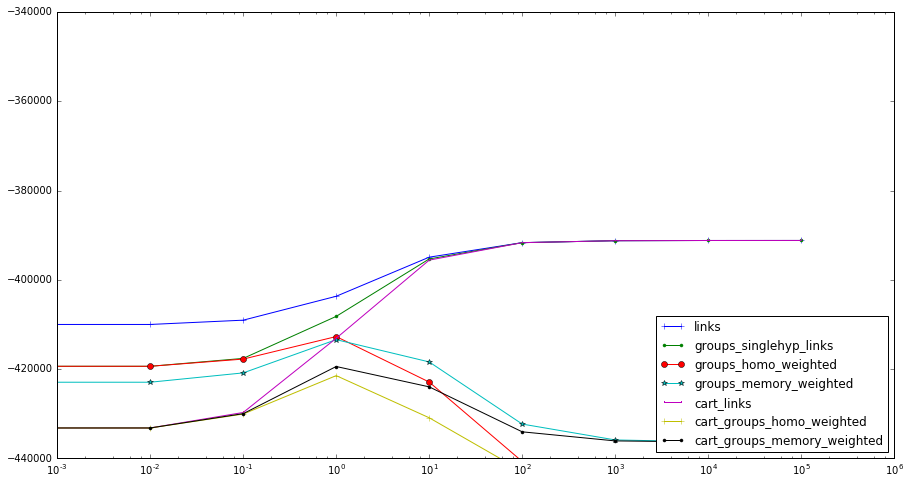

In [15]:
import itertools
marker = itertools.cycle((',','+','.','o','*'))
print(next(marker))

fig, ax = plt.subplots(1,1)

def f_filter(name):
    return True\
        and "perfect" not in name\
        and "random" not in name\
        and "red" not in name\
        and "blue" not in name\
        and ("weighted" in name or "links" in name)\
        and True
        

filtered = list(filter(lambda s:  f_filter(s[0]), experiments.items()))
for key, values in filtered:
    ax.plot(kappas_base, values,  marker = next(marker), label= key)

# random
#ax.set_ylim([-1700,-1600])
#ax.set_xlim([0.01,10000]) 

# links
#ax.set_ylim([-1300,-900])
#ax.set_xlim([0.01,10000])

# homo
#ax.set_ylim([-800,-0])
#ax.set_xlim([0.01,10000])

# memory
#ax.set_ylim([-400,-0])
#ax.set_xlim([0.01,10000])

# homo weighted
#ax.set_ylim([-1200,-800])
#ax.set_xlim([0.01,10000])

# memory weighted (5, 100, 10)
#ax.set_ylim([-1200,-800])
#ax.set_xlim([0.01,1000000])

# homo (100, 10000, 10)
#ax.set_ylim([-480000,-300000])
#ax.set_xlim([0.1,10000])

# random (100, 10000, 10)
#ax.set_ylim([-480000,-460000])
#ax.set_xlim([1,100000])

# links (100, 10000, 10)
#ax.set_ylim([-480000,-380000])
#ax.set_xlim([0.01,1000])

# homo weighted (100, 10000, 10)
#ax.set_ylim([-480000,-380000])
#ax.set_xlim([0.1,10000])

# memory (100, 10000, 10)
#ax.set_ylim([-480000,-380000])
#ax.set_xlim([0.1,10000])

# memory weighted (100, 10000, 10)
#ax.set_ylim([-480000,-300000])
#ax.set_xlim([0.1,10000])

ax.set_ylim([-440000,-340000])
ax.set_xlim([0.001,1000000])

plt.xscale('log')
plt.legend(loc = "lower right")

In [17]:
# write results to database

import trails.db as db
importlib.reload(db)
import pymysql
# pymysql.install_as_MySQLdb()
# con = pymysql.connect(
#     host='localhost',
#     port=3306,
#     user='user',
#     password='password',
#     db='db')

# name = "mixedtrails-synth-links"
# #name = "mixedtrails-synth-homo"
# #name = "mixedtrails-synth-mem"
# #name = "mixedtrails-synth-exp"
# for k, v in filtered:
#     print(k)
#     db.write(name, k, kappas_base, v, con, table="results_mixed_trails", replace=True)

# con.close()

OperationalError: (2003, "Can't connect to MySQL server on 'localhost' ([Errno 111] Connection refused)")

In [18]:
#fig.savefig("out/random.png")